In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 7-1 (Query Translation - Decomposition (Recursive))"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 7-1: Decomposition (Recursive)

![](images/07-01-decomposition-recursive.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-71dd424a-2902-4a56-ba74-40d05e39dc94-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

In [14]:
retriever = vectorstore.as_retriever()

## RAG

In [15]:
import textwrap

from langchain_core.prompts import ChatPromptTemplate

In [16]:
decomposition_prompt_template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}"""
decomposition_prompt = ChatPromptTemplate.from_template(decomposition_prompt_template)
decomposition_prompt.pretty_print()

================================ Human Message =================================

You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}


In [17]:
recursive_prompt_template = """Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>
"""

recursive_prompt = ChatPromptTemplate.from_template(recursive_prompt_template)
recursive_prompt.pretty_print()

================================ Human Message =================================

Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>



In [18]:
def print_prompts():
    print('=' * 100)
    prompt_template = """
    You are a helpful assistant that generates multiple sub-questions related to an input question.
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
    Generate multiple search queries related to: {question}"""
    print(prompt_template)

    print('=' * 100)
    
    prompt_template = textwrap.dedent("""
    You are a helpful assistant that generates multiple sub-questions related to an input question.
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
    Generate multiple search queries related to: {question}""").strip()
    print(prompt_template)
    print('=' * 100)
    
print_prompts()


    You are a helpful assistant that generates multiple sub-questions related to an input question.
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
    Generate multiple search queries related to: {question}
You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}


In [19]:
def format_qa_pair(question, answer):
    return f"Question: {question}  \nAnswer:\n{answer}\n\n"

In [20]:
query = "What are the main components of an LLM-powered autonomous agent system?"

### LangChain

In [21]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import chain, RunnableConfig
from pydantic import BaseModel, Field

#### Generate queries

In [22]:
@chain
def generate_sub_questions(query: str, config: RunnableConfig) -> list[str]:
    max_generated_sub_questions_count = config['configurable'].get("max_generated_sub_questions_count", 3)
    
    class SubQuestionsGenerator(BaseModel):
        sub_questions: list[str] = Field(
            ..., 
            description="List of generated sub-problems / sub-questions",
            max_items=max_generated_sub_questions_count
        )
    
    structured_llm = llm.with_structured_output(SubQuestionsGenerator, method="function_calling")
    chain = (
        decomposition_prompt
        | structured_llm
    )
    response = chain.invoke(query)
    questions = response.sub_questions + [query]
    
    return questions

questions = generate_sub_questions.invoke(query)
rprint(questions)

[
    'What is a large language model (LLM) and how does it function?',
    'What are the key components that make up an autonomous agent system?',
    'How do LLMs integrate with other technologies in an autonomous agent system?',
    'What are the main components of an LLM-powered autonomous agent system?'
]

In [23]:
rprint(generate_sub_questions.with_config(max_generated_sub_questions_count=5).invoke(query))

[
    'What is an LLM (Large Language Model) and how does it work?',
    'What are the essential components of an autonomous agent system?',
    'How do LLMs integrate with other components in an autonomous agent system?',
    'What role does natural language understanding play in LLM-powered autonomous agents?',
    'How do decision-making algorithms function within LLM-powered autonomous agents?',
    'What are the main components of an LLM-powered autonomous agent system?'
]

#### Define RAG chain

In [24]:
qa_pairs = ""

rag_chain = (
    {
        "context": itemgetter("question") | retriever, 
        "question": itemgetter("question"),
        "qa_pairs": itemgetter("qa_pairs")
    } 
    | recursive_prompt
    | llm
    | StrOutputParser()
)

for question in questions:
    answer = rag_chain.invoke(
        {
            "question": question,
            "qa_pairs": qa_pairs
        }
    )
    
    qa_pair = format_qa_pair(question, answer)
    display(Markdown(qa_pair))
    qa_pairs += qa_pair

Question: What is a large language model (LLM) and how does it function?                                           
Answer: A large language model (LLM) is an advanced type of artificial intelligence designed to understand,        
generate, and manipulate human language in a coherent manner. It functions by using statistical patterns learned   
from extensive datasets, which enable it to generate text that is contextually relevant and syntactically correct. 

Here's how an LLM operates:                                                                                        

 1 Training Process: LLMs are trained on vast amounts of text data from books, articles, websites, and other       
   sources. During this training process, they learn to predict the next word in a sentence given the previous     
   words, which allows them to develop an understanding of language structure, semantics, and context.             
 2 Tokenization: When processing text, LLMs convert input sentences into tokens, which are the basic units of      
   meaning. This tokenization allows the model to effectively analyze and generate language.                       
 3 Contextual Understanding: LLMs utilize mechanisms like attention mechanisms, which help them focus on relevant  
   portions of the input text to understand the meaning and generate appropriate responses. The size of the model  
   (number of parameters) typically enhances its capacity to retain context over larger spans of text.             
 4 Response Generation: After processing the input, the LLM generates a response by predicting the most probable   
   continuation or relevant information based on its learned patterns. It can also handle tasks like summarization,
   translation, and answering questions.                                                                           
 5 Task Management and Problem Solving: In advanced applications, LLMs can also function as agents that manage     
   complex tasks. They are capable of breaking down tasks into smaller subgoals, reflecting on their performance,  
   and refining their approaches for improved results. This is exemplified in systems where LLMs serve as the core 
   controller in autonomous agents, which can respond to user queries or execute multi-step tasks by interacting   
   with external tools and APIs.                                                                                   

In summary, LLMs are powerful AI models that leverage vast amounts of data and sophisticated algorithms to perform 
various language-related tasks, making them essential in numerous applications ranging from chatbots to autonomous 
systems. However, they can have limitations, such as inconsistencies or challenges in reliability, which are active
areas of research.

Question: What are the key components that make up an autonomous agent system?                                     
Answer: The key components that make up an autonomous agent system, particularly those powered by a large language 
model (LLM), include:                                                                                              

 1 Planning: The agent needs to plan its actions systematically, especially for complex tasks that involve multiple
   steps. This includes:                                                                                           
    • Task Decomposition: The ability to break down large tasks into smaller, manageable subgoals. This is often   
      facilitated through techniques like chain of thought (CoT), which encourages the agent to think step-by-step.
 2 Reflection and Refinement: The agent can self-evaluate its past actions, learn from mistakes, and refine its    
   approach for future tasks. This self-criticism aids in improving the quality of its results over time.          
 3 Memory: An effective autonomous agent system often includes a memory component that helps the agent retain      
   information from past interactions and tasks, allowing it to refer back to previous knowledge and experiences to
   inform current decisions.                                                                                       

These components work together to enable the autonomous agent to operate effectively, manage complex tasks, and    
adapt based on its experiences.

Question: How do LLMs integrate with other technologies in an autonomous agent system?                             
Answer: Large language models (LLMs) integrate with other technologies in an autonomous agent system by serving as 
the core controller that drives decision-making and task execution. Here are the key ways LLMs interact with other 
components and technologies within such systems:                                                                   

 1 Planning and Task Management: LLMs are central to planning processes within the autonomous agent. They leverage 
   their ability to break down complex tasks into smaller, manageable subgoals through techniques like chain of    
   thought (CoT) prompting. This enables the agent to systematically approach multi-step tasks, providing a        
   structured way to handle complexity.                                                                            
 2 Reflection and Refinement: LLMs can engage in self-reflection and self-criticism of their decisions, learning   
   from past actions to improve future performance. This capability allows the agent to refine its approach based  
   on experiences, leading to enhanced problem-solving outcomes.                                                   
 3 Natural Language Interface: LLMs often act as the natural language interface between the user and various       
   external components, such as memory systems and tools. They convert user queries into actions and responses,    
   processing input and generating coherent output. However, the reliability of this interface can be a challenge, 
   as LLMs may occasionally produce formatting errors or may not follow instructions precisely.                    
 4 Interaction with External Tools and APIs: LLMs can direct and manage interactions with external tools and APIs, 
   expanding the capabilities of the autonomous agent beyond just language understanding. They can interpret       
   results from these interactions and adjust the agent's actions accordingly, demonstrating their role in         
   integrating diverse technologies.                                                                               

In summary, LLMs create a cohesive integration point in an autonomous agent system, allowing for seamless planning,
problem-solving, and interaction with both users and external technology components, thereby enhancing the overall 
functionality and effectiveness of the system.

Question: What are the main components of an LLM-powered autonomous agent system?                                  
Answer: The main components of an LLM-powered autonomous agent system include:                                     

 1 Planning: This involves the systematic organization of actions, particularly for complex tasks that necessitate 
   multiple steps. Key aspects include:                                                                            
    • Task Decomposition: The agent breaks down larger tasks into smaller, manageable subgoals, often utilizing    
      techniques such as chain of thought (CoT) prompting to ensure a structured approach.                         
 2 Reflection and Refinement: The agent is capable of self-evaluation, allowing it to learn from past actions,     
   identify mistakes, and improve its future performance. This iterative self-criticism enhances the quality of    
   outcomes over time.                                                                                             
 3 Memory: An effective autonomous agent system often incorporates a memory component, which enables the agent to  
   retain information from past interactions and tasks. This capability allows it to leverage previous knowledge   
   and experiences in making informed decisions.                                                                   
 4 Natural Language Interface: LLMs serve as the interface that facilitates communication between the user and the 
   system. They convert user queries into actions and manage responses, although there may be challenges with      
   reliability and consistency in understanding user instructions.                                                 
 5 Integration with External Tools and APIs: The agent interacts with various external components and systems to   
   expand its functionality beyond mere language processing. This integration allows for a broader range of actions
   and improved task execution.                                                                                    

These components work together to enable the autonomous agent to function effectively, manage complex tasks, and   
adapt based on its experiences.

### LangGraph

In [25]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [26]:
class State(TypedDict):
    question: str
    all_questions: list[str]
    current_question_idx: int
    qa_pairs: list[str]
    context: list[Document]
    answer: str

In [27]:
def generate_sub_questions(state: State, config: RunnableConfig) -> list[str]:
    max_generated_sub_questions_count = config['configurable'].get("max_generated_sub_questions_count", 3)
    query = state['question']
    
    class SubQuestionsGenerator(BaseModel):
        sub_questions: list[str] = Field(
            ..., 
            description="List of generated sub-problems / sub-questions",
            max_items=max_generated_sub_questions_count
        )
    
    structured_llm = llm.with_structured_output(SubQuestionsGenerator, method="function_calling")
    chain = (
        decomposition_prompt
        | structured_llm
    )
    response = chain.invoke(query)
    questions = response.sub_questions + [query]
    
    return {"all_questions": questions, "current_question_idx": 0}


def retrieve_docs(state: State):
    question = state["all_questions"][state["current_question_idx"]]
    retrieved_docs = vectorstore.similarity_search(question)
    return {"context": retrieved_docs}


def generate_answer(state: State):
    chain = (
        recursive_prompt
        | llm
        | StrOutputParser()
    )

    question = state["all_questions"][state["current_question_idx"]]
    answer = chain.invoke(
        {
            "question": question,
            "qa_pairs": state.get("qa_pairs", ""),
            "context": state["context"]
        }
    )
    qa_pair = format_qa_pair(question, answer)
    qa_pairs = state.get("qa_pairs", "") + qa_pair

    if state["current_question_idx"] == len(state['all_questions']) - 1:
        return {"answer": answer}
    else:
        return {"qa_pairs": qa_pairs, "current_question_idx": state["current_question_idx"] + 1}


def check_answer_status(state: State) -> Literal["Next sub-question", "Final answer"]:
    if state.get("answer"):
        return "Final answer"
    else:
        return "Next sub-question"

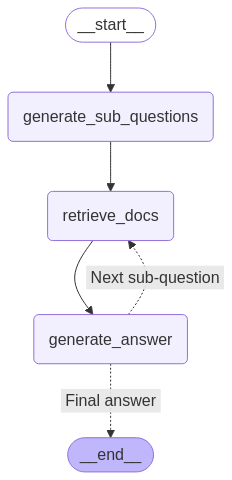

In [28]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_sub_questions", generate_sub_questions)
graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_sub_questions")
graph_builder.add_edge("generate_sub_questions", "retrieve_docs")
graph_builder.add_edge("retrieve_docs", "generate_answer")
graph_builder.add_conditional_edges(
    "generate_answer", 
    check_answer_status, 
    {
        "Next sub-question": "retrieve_docs",
        "Final answer": END
    }
)

graph = graph_builder.compile()
graph

In [29]:
config = {
    "configurable": {
        "max_generated_sub_questions_count": 3
    }
}

for stream_mode, event in graph.stream(
    {"question": query}, 
    stream_mode=["messages", "updates"],
    config=config
):
    match stream_mode:
        case "messages":
            message, metadata = event
            print(message.content, end="", flush=True)
        case "updates":
            rprint(event)

display(Markdown(event['generate_answer']['answer']))

{
    'generate_sub_questions': {
        'all_questions': [
            'What is a large language model (LLM) and how does it function as a core component of an autonomous 
agent system?',
            'What are the crucial hardware requirements for operating an LLM-powered autonomous agent?',
            'How do different components of an LLM-powered autonomous agent interact with each other to achieve 
autonomy?',
            'What are the main components of an LLM-powered autonomous agent system?'
        ],
        'current_question_idx': 0
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='55c59502-88e0-431e-a6a6-0849807e2365',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='528a5e02-d0f2-46a5-b82c-88844346f021',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='2fa4551e-4ee8-473a-a2b3-f9f0023916ae',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='7c0fa5e6-9243-49d0-83a4-e2f450a7964e',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  
= "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = 
"https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting 
elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem 
Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\n[3] Liu et al. “Chain of Hindsight 
Aligns Language Models with Feedback\n“ arXiv preprint arXiv:2302.02676 (2023).\n[4] Liu et al. “LLM+P: Empowering 
Large Language Models with Optimal Planning Proficiency” arXiv preprint arXiv:2304.11477 (2023).\n[5] Yao et al. 
“ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.\n[6] Google Blog. “Announcing ScaNN: 
Efficient Vector Simila

A large language model (LLM) is an advanced type of artificial intelligence that is designed to understand and generate human-like text. These models are trained on vast datasets of text from the internet and other diverse sources, enabling them to perform a wide range of language tasks, such as writing, summarizing, translating, and answering questions.

In the context of an autonomous agent system, an LLM functions as the "brain" or central controller of the system. It integrates several critical functions that allow the agent to effectively handle complex tasks. Here are the key components of how an LLM operates within such a system:

1. **Planning**: The LLM helps the agent to plan its actions by identifying the necessary steps to accomplish a given task. This involves breaking down larger tasks into smaller, more manageable subgoals, which allows the agent to approach complicated problems methodically.

2. **Subgoal Decomposition**: By utilizing techniques such as "Chain of Though

{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function as a core component of
an autonomous agent system?  \nAnswer:\nA large language model (LLM) is an advanced type of artificial intelligence
that is designed to understand and generate human-like text. These models are trained on vast datasets of text from
the internet and other diverse sources, enabling them to perform a wide range of language tasks, such as writing, 
summarizing, translating, and answering questions.\n\nIn the context of an autonomous agent system, an LLM 
functions as the "brain" or central controller of the system. It integrates several critical functions that allow 
the agent to effectively handle complex tasks. Here are the key components of how an LLM operates within such a 
system:\n\n1. **Planning**: The LLM helps the agent to plan its actions by identifying the necessary steps to 
accomplish a given task. This involves breaking down larger tasks into smaller, more manageable subgoals, which 
allows the agent to approach complicated problems methodically.\n\n2. **Subgoal Decomposition**: By utilizing 
techniques such as "Chain of Thought" (CoT) prompting, the LLM can guide the agent to think through complex 
problems step-by-step. This technique encourages the model to decompose hard tasks into simpler ones, aiding in the
understanding and execution of the required actions.\n\n3. **Reflection and Refinement**: The agent can utilize the
LLM\'s capabilities for self-assessment and learning. It reflects on past actions, critiques its decisions, and 
revises its approach based on previous experiences, improving future performance.\n\n4. **Natural Language 
Interface**: LLMs often serve as the primary interface between users and the agent\'s various components, including
memory and tools. While this allows for intuitive interaction, it\'s important to note that the reliability of the 
model\'s outputs can vary, necessitating careful parsing and validation of the information generated.\n\nIn 
summary, a large language model plays a foundational role in autonomous agents by enabling them to plan, reflect, 
and communicate effectively, thereby enhancing their problem-solving capabilities and overall functionality.\n\n',
        'current_question_idx': 1
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='55c59502-88e0-431e-a6a6-0849807e2365',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='2fa4551e-4ee8-473a-a2b3-f9f0023916ae',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='528a5e02-d0f2-46a5-b82c-88844346f021',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='5c38295c-953c-4e16-9db2-88a47a5d73be',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered 
agents, I start to see a couple common limitations:'
            )
        ]
    }
}

To effectively operate an LLM-powered autonomous agent, several crucial hardware requirements must be met. These requirements stem from the demands of the large language model (LLM) itself and the overall system that supports the autonomous agent. Here are the key hardware considerations:

1. **CPU and GPU Performance**: Powerful CPUs and GPUs are essential for training and running large language models. High-performance GPUs are particularly important for handling the computational load of running LLMs in real-time, as they provide the necessary parallel processing capabilities.

2. **Memory (RAM)**: Sufficient RAM is crucial, as LLMs often require a substantial amount of memory to store model weights and handle intermediate computations. Systems should be equipped with enough RAM to accommodate the size of the model and the data processed during operation.

3. **Storage**: Fast and high-capacity storage solutions, such as SSDs, are important for storing the large datasets used to tra

{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function as a core component of
an autonomous agent system?  \nAnswer:\nA large language model (LLM) is an advanced type of artificial intelligence
that is designed to understand and generate human-like text. These models are trained on vast datasets of text from
the internet and other diverse sources, enabling them to perform a wide range of language tasks, such as writing, 
summarizing, translating, and answering questions.\n\nIn the context of an autonomous agent system, an LLM 
functions as the "brain" or central controller of the system. It integrates several critical functions that allow 
the agent to effectively handle complex tasks. Here are the key components of how an LLM operates within such a 
system:\n\n1. **Planning**: The LLM helps the agent to plan its actions by identifying the necessary steps to 
accomplish a given task. This involves breaking down larger tasks into smaller, more manageable subgoals, which 
allows the agent to approach complicated problems methodically.\n\n2. **Subgoal Decomposition**: By utilizing 
techniques such as "Chain of Thought" (CoT) prompting, the LLM can guide the agent to think through complex 
problems step-by-step. This technique encourages the model to decompose hard tasks into simpler ones, aiding in the
understanding and execution of the required actions.\n\n3. **Reflection and Refinement**: The agent can utilize the
LLM\'s capabilities for self-assessment and learning. It reflects on past actions, critiques its decisions, and 
revises its approach based on previous experiences, improving future performance.\n\n4. **Natural Language 
Interface**: LLMs often serve as the primary interface between users and the agent\'s various components, including
memory and tools. While this allows for intuitive interaction, it\'s important to note that the reliability of the 
model\'s outputs can vary, necessitating careful parsing and validation of the information generated.\n\nIn 
summary, a large language model plays a foundational role in autonomous agents by enabling them to plan, reflect, 
and communicate effectively, thereby enhancing their problem-solving capabilities and overall 
functionality.\n\nQuestion: What are the crucial hardware requirements for operating an LLM-powered autonomous 
agent?  \nAnswer:\nTo effectively operate an LLM-powered autonomous agent, several crucial hardware requirements 
must be met. These requirements stem from the demands of the large language model (LLM) itself and the overall 
system that supports the autonomous agent. Here are the key hardware considerations:\n\n1. **CPU and GPU 
Performance**: Powerful CPUs and GPUs are essential for training and running large language models. 
High-performance GPUs are particularly important for handling the computational load of running LLMs in real-time, 
as they provide the necessary parallel processing capabilities.\n\n2. **Memory (RAM)**: Sufficient RAM is crucial, 
as LLMs often require a substantial amount of memory to store model weights and handle intermediate computations. 
Systems should be equipped with enough RAM to accommodate the size of the model and the data processed during 
operation.\n\n3. **Storage**: Fast and high-capacity storage solutions, such as SSDs, are important for storing the
large datasets used to train the LLMs and for quick access to the model files during inference. The storage should 
also allow for rapid read/write speeds to manage real-time data processing.\n\n4. **Networking Capabilities**: For 
distributed systems or cloud-based applications, robust networking hardware is required to facilitate communication
between different components of the system. High bandwidth and low latency are necessary to ensure that the LLM can
effectively interact with other modules, such as memory and tools.\n\n5. **Power Supply and Cooling**: The hardware
for running LLMs can be pow

{
    'retrieve_docs': {
        'context': [
            Document(
                id='2fa4551e-4ee8-473a-a2b3-f9f0023916ae',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='55c59502-88e0-431e-a6a6-0849807e2365',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='528a5e02-d0f2-46a5-b82c-88844346f021',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='eab2657d-ba82-4c8b-9814-b5b8926f86d2',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LL

In an LLM-powered autonomous agent system, various components work together in a coordinated manner to achieve autonomy. The primary components and their interactions can be summarized as follows:

1. **Planning**: The large language model (LLM) serves as the brain of the agent, facilitating planning by identifying necessary actions to accomplish tasks. It analyzes the overall goal and determines the sequence of steps required for execution.

2. **Subgoal Decomposition**: The LLM employs techniques such as Chain of Thought (CoT) prompting to break down complex tasks into smaller, manageable subgoals. This approach not only simplifies the planning process but also helps the agent structure its thought process and actions logically.

3. **Execution and Memory**: As the agent progresses through subgoals, it interacts with its memory component to retain relevant information, learned experiences, and previously executed actions. This memory allows the agent to recall past successes and fail

{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function as a core component of
an autonomous agent system?  \nAnswer:\nA large language model (LLM) is an advanced type of artificial intelligence
that is designed to understand and generate human-like text. These models are trained on vast datasets of text from
the internet and other diverse sources, enabling them to perform a wide range of language tasks, such as writing, 
summarizing, translating, and answering questions.\n\nIn the context of an autonomous agent system, an LLM 
functions as the "brain" or central controller of the system. It integrates several critical functions that allow 
the agent to effectively handle complex tasks. Here are the key components of how an LLM operates within such a 
system:\n\n1. **Planning**: The LLM helps the agent to plan its actions by identifying the necessary steps to 
accomplish a given task. This involves breaking down larger tasks into smaller, more manageable subgoals, which 
allows the agent to approach complicated problems methodically.\n\n2. **Subgoal Decomposition**: By utilizing 
techniques such as "Chain of Thought" (CoT) prompting, the LLM can guide the agent to think through complex 
problems step-by-step. This technique encourages the model to decompose hard tasks into simpler ones, aiding in the
understanding and execution of the required actions.\n\n3. **Reflection and Refinement**: The agent can utilize the
LLM\'s capabilities for self-assessment and learning. It reflects on past actions, critiques its decisions, and 
revises its approach based on previous experiences, improving future performance.\n\n4. **Natural Language 
Interface**: LLMs often serve as the primary interface between users and the agent\'s various components, including
memory and tools. While this allows for intuitive interaction, it\'s important to note that the reliability of the 
model\'s outputs can vary, necessitating careful parsing and validation of the information generated.\n\nIn 
summary, a large language model plays a foundational role in autonomous agents by enabling them to plan, reflect, 
and communicate effectively, thereby enhancing their problem-solving capabilities and overall 
functionality.\n\nQuestion: What are the crucial hardware requirements for operating an LLM-powered autonomous 
agent?  \nAnswer:\nTo effectively operate an LLM-powered autonomous agent, several crucial hardware requirements 
must be met. These requirements stem from the demands of the large language model (LLM) itself and the overall 
system that supports the autonomous agent. Here are the key hardware considerations:\n\n1. **CPU and GPU 
Performance**: Powerful CPUs and GPUs are essential for training and running large language models. 
High-performance GPUs are particularly important for handling the computational load of running LLMs in real-time, 
as they provide the necessary parallel processing capabilities.\n\n2. **Memory (RAM)**: Sufficient RAM is crucial, 
as LLMs often require a substantial amount of memory to store model weights and handle intermediate computations. 
Systems should be equipped with enough RAM to accommodate the size of the model and the data processed during 
operation.\n\n3. **Storage**: Fast and high-capacity storage solutions, such as SSDs, are important for storing the
large datasets used to train the LLMs and for quick access to the model files during inference. The storage should 
also allow for rapid read/write speeds to manage real-time data processing.\n\n4. **Networking Capabilities**: For 
distributed systems or cloud-based applications, robust networking hardware is required to facilitate communication
between different components of the system. High bandwidth and low latency are necessary to ensure that the LLM can
effectively interact with other modules, such as memory and tools.\n\n5. **Power Supply and Cooling**: The hardware
for running LLMs can be pow

{
    'retrieve_docs': {
        'context': [
            Document(
                id='55c59502-88e0-431e-a6a6-0849807e2365',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='2fa4551e-4ee8-473a-a2b3-f9f0023916ae',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='528a5e02-d0f2-46a5-b82c-88844346f021',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='eab2657d-ba82-4c8b-9814-b5b8926f86d2',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LL

The main components of an LLM-powered autonomous agent system include:

1. **Large Language Model (LLM)**: The core of the system, serving as the "brain" that processes natural language and manages the agent's functions. It integrates various capabilities essential for autonomous operations.

2. **Planning**: The LLM assists in planning by identifying the necessary actions and determining the sequence of steps required to achieve specific goals.

3. **Subgoal Decomposition**: Utilizing techniques like Chain of Thought (CoT) prompting, the agent breaks down complex tasks into smaller, manageable subgoals, enabling more efficient handling of overall tasks.

4. **Reflection and Refinement**: The agent can reflect on its past actions, assess its decision-making, and learn from previous experiences, allowing for improved strategies in future operations.

5. **Memory**: A memory component allows the agent to retain relevant information, learned experiences, and previously executed actions, e

{
    'generate_answer': {
        'answer': 'The main components of an LLM-powered autonomous agent system include:\n\n1. **Large Language 
Model (LLM)**: The core of the system, serving as the "brain" that processes natural language and manages the 
agent\'s functions. It integrates various capabilities essential for autonomous operations.\n\n2. **Planning**: The
LLM assists in planning by identifying the necessary actions and determining the sequence of steps required to 
achieve specific goals.\n\n3. **Subgoal Decomposition**: Utilizing techniques like Chain of Thought (CoT) 
prompting, the agent breaks down complex tasks into smaller, manageable subgoals, enabling more efficient handling 
of overall tasks.\n\n4. **Reflection and Refinement**: The agent can reflect on its past actions, assess its 
decision-making, and learn from previous experiences, allowing for improved strategies in future operations.\n\n5. 
**Memory**: A memory component allows the agent to retain relevant information, learned experiences, and previously
executed actions, enhancing its ability to recall successes and failures for better decision-making.\n\n6. 
**Natural Language Interface**: This component facilitates communication between the LLM and external tools or 
memory, allowing for intuitive interactions, although it may present challenges due to potential reliability issues
with the model\'s outputs.\n\nTogether, these components create a synergistic environment that enhances the 
agent\'s autonomy and problem-solving capabilities, enabling it to navigate and execute complex tasks 
independently.'
    }
}

The main components of an LLM-powered autonomous agent system include:                                             

 1 Large Language Model (LLM): The core of the system, serving as the "brain" that processes natural language and  
   manages the agent's functions. It integrates various capabilities essential for autonomous operations.          
 2 Planning: The LLM assists in planning by identifying the necessary actions and determining the sequence of steps
   required to achieve specific goals.                                                                             
 3 Subgoal Decomposition: Utilizing techniques like Chain of Thought (CoT) prompting, the agent breaks down complex
   tasks into smaller, manageable subgoals, enabling more efficient handling of overall tasks.                     
 4 Reflection and Refinement: The agent can reflect on its past actions, assess its decision-making, and learn from
   previous experiences, allowing for improved strategies in future operations.                                    
 5 Memory: A memory component allows the agent to retain relevant information, learned experiences, and previously 
   executed actions, enhancing its ability to recall successes and failures for better decision-making.            
 6 Natural Language Interface: This component facilitates communication between the LLM and external tools or      
   memory, allowing for intuitive interactions, although it may present challenges due to potential reliability    
   issues with the model's outputs.                                                                                

Together, these components create a synergistic environment that enhances the agent's autonomy and problem-solving 
capabilities, enabling it to navigate and execute complex tasks independently.